In [1]:
from voxel import *

## Numerical Approximations

In [2]:
# find integer ranges M = [mx1, mx2] x [my1, my2] ( x [mz1, mz2])
# such that G = B . M contains all points that fall into [-2pi/delta_L / 2, 2pi/delta_L / 2]^d
def get_mesh_coords(A, L, N):
    d = A.shape[0]
    delta_L = L / N
    
    extreme_point = np.full((d,), 1/(2*delta_L))
    
    if d == 2:
        extreme_points = np.array([[1,1], [-1,1], [1,-1], [-1,-1]]) * extreme_point # (4,2)
        r_extreme_points = A.T.dot(extreme_points.T) # (2,4)
        
        lower = np.min(np.floor(r_extreme_points), axis=1)
        upper = np.max(np.ceil(r_extreme_points), axis=1)+1
        
        return np.arange(lower[0], upper[0]), np.arange(lower[1], upper[1])
    if d == 3:
        extreme_points = np.array([[1,1,1], [-1,1,1], [1,-1,1], [1,1,-1],
                                   [-1,-1,-1], [1,-1,-1], [-1,1,-1],[-1,-1,1]]) * extreme_point # (8,3)
        r_extreme_points = A.T.dot(extreme_points.T) # (3,8)
        
        lower = np.min(np.floor(r_extreme_points), axis=1)
        upper = np.max(np.ceil(r_extreme_points), axis=1)+1
        
        return np.arange(lower[0], upper[0]), np.arange(lower[1], upper[1]), np.arange(lower[2], upper[2])

In [3]:
def make_descriptor(G, SG, L, N):
    d, n = G.shape
    absSG = np.abs(SG)
    voxel_width = 2*np.pi / L
    descriptor_width = voxel_width * N # = 2*pi/delta_L
    
    descriptor_shape = (0,)
    if d == 2:
        descriptor_shape = (N,N)
    if d == 3:
        descriptor_shape = (N,N,N)
        
    descriptor = np.zeros(descriptor_shape)
    
    for i in range(n):
        g = G[:,i]
        index = np.floor((g + descriptor_width/2) / voxel_width).astype(np.int)
        if np.all(0 <= index) and np.all(index < N):
            if d == 2:
                descriptor[index[1], index[0]] += absSG[i] # rows = y-axis, cols = x-axis
            if d == 3:
                descriptor[index[1], index[0], index[2]] += absSG[i]

    return descriptor

In [4]:
def get_nD_gaussian(mus, sigma, K, A):
    new_mus = []
    d = A.shape[0]
    
    if d == 2:
        for kx in np.arange(-K,K+1):
            for ky in np.arange(-K,K+1):
                for mu in mus:
                    Ak = A.dot([kx,ky])
                    new_mus.append(Ak+mu)
    if d == 3:
        for kx in np.arange(-K,K+1):
            for ky in np.arange(-K,K+1):
                for kz in np.arange(-K,K+1):
                    for mu in mus:
                        Ak = A.dot([kx,ky,kz])
                        new_mus.append(Ak+mu)
    
    new_mus = np.array(new_mus)
    nmus, d = new_mus.shape
    
    mus3 = new_mus.T.reshape(d,1,nmus)
    
    def s(X):
        d2, n = X.shape
        assert(d == d2)
        
        X_centered = X.reshape(d,n,1) - mus3 # (d, n, nmus)
        
        XX = np.sum(X_centered * X_centered, axis=0) # (n, nmus)
        
        EXX = np.exp(- XX / (2 * sigma**2)) # (n, nmus)
        
        res = np.sum(EXX, axis=1) # (n,)

        return res / (2*np.pi * sigma**2)
        
    return s

In [111]:
def plot_2D_reciprocal_lattice(B, mx, my, G, SG, xlims=None, ylims=None, L=None, N=None):
    absSG = np.abs(SG)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
    ax1.set_aspect('equal')
    cmesh = ax1.pcolormesh(mx, my, absSG.reshape((len(my), len(mx))), shading='auto')
    plt.colorbar(cmesh, ax=ax1)
    
    ax1.set_xlabel(f"b1 = ({B[0,0]:.2f}, {B[1,0]:.2f})")
    ax1.set_ylabel(f"b2 = ({B[0,1]:.2f}, {B[1,1]:.2f})")

    
    max_sg = absSG.max()
    colors = [(1.,0.,0.,v) for v in np.maximum(absSG.reshape(-1) / max_sg, 0.1)]
    ax2.scatter(G[0,:], G[1,:], c=colors)
    if L and N:   
        e = 2*np.pi/L * N / 2
        ticks = np.arange(-e, e, 2*np.pi/L)
        plt.xticks(ticks, rotation=90)
        ax2.set_yticks(ticks)
        ax2.set_xlim((-e,e))
        ax2.set_ylim((-e,e))
        plt.suptitle(f"L = {L} Å, N = {N}")
        ax2.grid(True)
    else:
        if xlims:
            ax2.set_xlim(xlims)
        if ylims:
            ax2.set_ylim(ylims)
    
    plt.show()

In [6]:
def reciprocal_lattice(s, A, mx=None, my=None, mz=None, n=101):
    d = A.shape[0]
    
    B = 2*np.pi * np.linalg.inv(A).T
    
    xi = np.linspace(0,1,n)
    
    
    if d == 2:
        x1, x2 = np.meshgrid(xi, xi)
        X = np.vstack((x1.reshape(1,-1), x2.reshape(1,-1))) # (2,n*n) n = len(xi)
        
        m1, m2 = np.meshgrid(mx, my)
        M = np.vstack((m1.reshape(1,-1), m2.reshape(1,-1))) # (2,m) m = len(mx) * len(my)
    elif d == 3:
        x1, x2, x3 = np.meshgrid(xi, xi, xi)
        X = np.vstack((x1.reshape(1,-1), x2.reshape(1,-1), x3.reshape(1,-1))) # (2,n*n*n) n = len(xi)
        
        m1, m2, m3 = np.meshgrid(mx, my, mz)
        M = np.vstack((m1.reshape(1,-1), m2.reshape(1,-1), m3.reshape(1,-1))) # (3,m) m = len(mx) * len(my) * len(mz)

        
    R = A.dot(X) # (d,n^d)
    G = B.dot(M) # (d,m)
    
    XR = R.T.dot(G) # (n^d, m) (= 2 * np.pi * X.T.dot(M))
    
    E = np.exp(-1j * XR) # (n^d, m)

    SR = s(R) # (n^d, )

    delta = (xi[1] - xi[0])**d
    SG = delta * SR.dot(E) # (m,)
    
    return (B, G, SG)

In [7]:
def reciprocal_lattice_gaussian(A, mus, sigma, mx=None, my=None, mz=None):
    d = A.shape[0]
    
    B = 2*np.pi * np.linalg.inv(A).T
    
    if d == 2:
        m1, m2 = np.meshgrid(mx, my)
        M = np.vstack((m1.reshape(1,-1), m2.reshape(1,-1))) # (2,m) m = len(mx) * len(mz)
    elif d == 3:
        m1, m2, m3 = np.meshgrid(mx, my, mz)
        M = np.vstack((m1.reshape(1,-1), m2.reshape(1,-1), m3.reshape(1,-1))) # (3,m) m = len(mx) * len(my) * len(mz)

    G = B.dot(M) # (d,m)
    
    GG = np.linalg.norm(G, axis=0) ** 2 # (m,)
    
    expGG = np.exp(-sigma**2 / 2 * GG) # (m,)

    muG = mus.dot(G) # (n,d) * (d, m) = (n, m)
    
    expmuG = np.exp(-1j * muG) # (n, m)
    
    SG = 1/np.linalg.det(A) * expGG * np.sum(expmuG, axis=0) #(m*d,)

    return (B, G, SG)

In [8]:
# a = 1
# alpha = 45 deg = pi/4
f = 2 * np.sin(np.pi/8)
e = np.cos(np.pi/8)
r = f*np.sqrt(4-f**2)/(4+2*f)
print(np.cos(np.pi/8)*(e-r), np.sin(np.pi/8)*(e-r))
print(np.cos(np.pi/8)*(e+r), np.sin(np.pi/8)*(e+r))

0.6173165676349102 0.2557008945919878
1.0897902135516373 0.4514058865945597


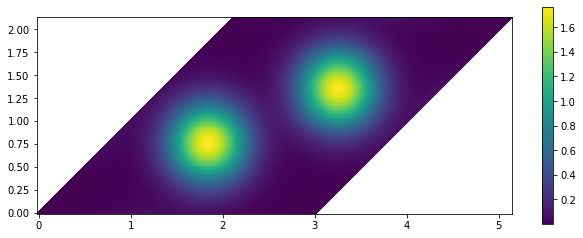

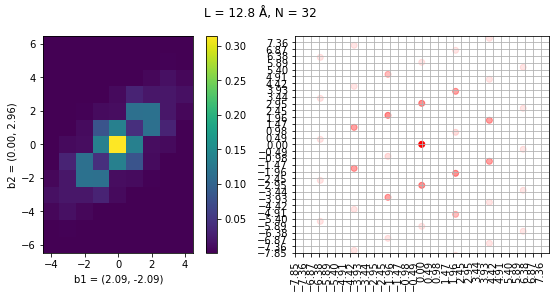

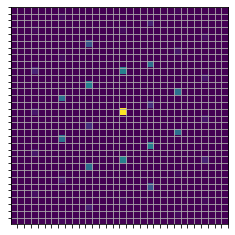

In [112]:
L = 12.8
N = 32
A = np.array([
    [1., np.sqrt(0.5)],
    [0., np.sqrt(0.5)]
]) * 3
gauss = get_nD_gaussian(np.array([[0.6173,0.2557], [1.0898, 0.4514]])*3, 0.3, 3, A)
xi, sr = bravais_lattice(gauss, A)
plot_2D_realspace_lattice(A, xi, sr)
mx, my = get_mesh_coords(A, L, N)
B, G, SG = reciprocal_lattice(gauss, A, mx, my, n=101)
plot_2D_reciprocal_lattice(B, mx, my, G, SG, L=L, N=N)

descriptor = make_descriptor(G, SG, L, N)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.imshow(descriptor, origin='lower')
plt.xticks(np.arange(0,N)+0.5)
plt.yticks(np.arange(0,N)+0.5)
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.grid(True)

In [113]:
from numpy.fft import fftn

def reciprocal_lattice_fft(s, A, mx=None, my=None, mz=None, n=101):
    d = A.shape[0]
    
    B = 2*np.pi * np.linalg.inv(A).T
    
    xi = np.linspace(0,1,n)
    x_shape = (0,)
    
    if d == 2:
        x1, x2 = np.meshgrid(xi, xi)
        X = np.vstack((x1.reshape(1,-1), x2.reshape(1,-1))) # (2,n*n) n = len(xi)
        x_shape = (n,n)
        
        m1, m2 = np.meshgrid(mx, my)
        M = np.vstack((m1.reshape(1,-1), m2.reshape(1,-1))) # (2,m) m = len(mx) * len(my)
        
    elif d == 3:
        x1, x2, x3 = np.meshgrid(xi, xi, xi)
        X = np.vstack((x1.reshape(1,-1), x2.reshape(1,-1), x3.reshape(1,-1))) # (2,n*n*n) n = len(xi)
        x_shape = (n,n,n)
        
        m1, m2, m3 = np.meshgrid(mx, my, mz)
        M = np.vstack((m1.reshape(1,-1), m2.reshape(1,-1), m3.reshape(1,-1))) # (3,m) m = len(mx) * len(my) * len(mz)

        
    R = A.dot(X) # (d,n^d)
    G = B.dot(M) # (d,m)

    SR = s(R) # (n^d, )

    delta = (xi[1] - xi[0])**d
    SG_ftt = delta * fftn(SR.reshape(x_shape)) # (n,n[,n])
    
    SG = np.zeros((G.shape[1],), dtype=np.complex64)
    for i in range(G.shape[1]):
        index = M[:,i].astype(np.int)
        index[index < 0] += n
        SG[i] = SG_ftt[tuple(index)]
        
    
    return (B, G, SG)

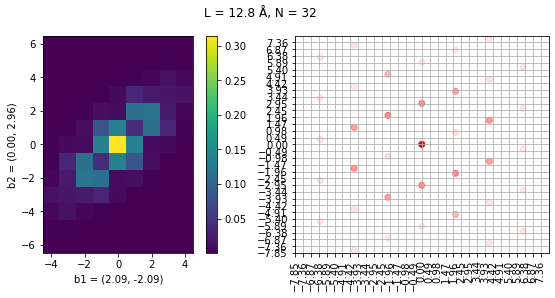

In [115]:
B, G, SG = reciprocal_lattice_fft(gauss, A, mx=mx, my=my, n=101)
plot_2D_reciprocal_lattice(B, mx, my, G, SG, L=L, N=N)

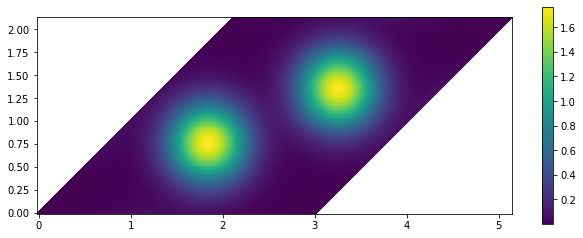

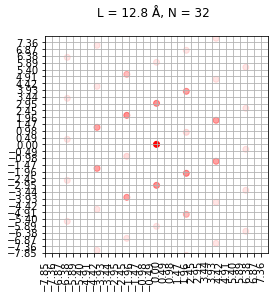

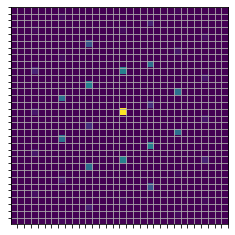

In [10]:
L = 12.8
N = 32
A = np.array([
    [1., np.sqrt(0.5)],
    [0., np.sqrt(0.5)]
]) * 3
mus = np.array([[0.6173,0.2557], [1.0898, 0.4514]])*3
sigma = 0.3

gauss = get_nD_gaussian(mus, sigma, 3, A)
xi, sr = bravais_lattice(gauss, A)
plot_2D_realspace_lattice(A, xi, sr)

mx, my = get_mesh_coords(A, L, N)
B, G, SG = reciprocal_lattice_gaussian(A, mus, sigma, mx, my)
plot_2D_reciprocal_lattice(B, G, SG, L=L, N=N)

descriptor = make_descriptor(G, SG, L, N)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.imshow(descriptor, origin='lower')
plt.xticks(np.arange(0,N)+0.5)
plt.yticks(np.arange(0,N)+0.5)
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.grid(True)

In [138]:
def plot_3D_reciprocal_lattice(B, G, SG, xlims=None, ylims=None, zlims=None, L=None, N=None):
    absSG = np.abs(SG)
        
    fig = plt.figure(figsize=(4,4))
    ax = Axes3D(fig)
    
    max_sg = absSG.max()
    colors = [(1.,0.,0.,v) for v in np.maximum(absSG.reshape(-1) / max_sg, 0.1)]
    
    if L and N:   
        e = 2*np.pi/L * N / 2
        ax.set_xlim((-e,e))
        ax.set_ylim((-e,e))
        ax.set_zlim((-e,e))
        plt.suptitle(f"L = {L} Å, N = {N}")
        plt.grid(True)
        
        for i in range(len(colors)):
            if not np.all((-e <= G[:,i]) & (G[:,i] <= e)):
                colors[i] = (0.,0.,0.,0.)
    else:         
        if xlims:
            ax.set_xlim(xlims)
        if ylims:
            ax.set_ylim(ylims)
        if zlims:
            ax.set_zlim(zlims)
    
    ax.scatter(G[0,:], G[1,:], G[2,:], c=colors)
    
    plt.show()

In [116]:
L = 12.8
N = 32
A = np.eye(3)
mus =  np.array([[0.,0.,0.]])
sigma = 0.1

mx, my, mz = get_mesh_coords(A, L, N)

In [144]:
%%time
B, G, SG = reciprocal_lattice_gaussian(A, mus, sigma, mx, my, mz)

CPU times: user 992 µs, sys: 332 µs, total: 1.32 ms
Wall time: 768 µs


In [157]:
%%time
gauss = get_nD_gaussian(mus, sigma, 3, A)
B2, G2, SG2 = reciprocal_lattice(gauss, A, mx, my, mz, n=101)

CPU times: user 32.8 s, sys: 1min 17s, total: 1min 49s
Wall time: 3min 37s


In [117]:
%%time
gauss = get_nD_gaussian(mus, sigma, 3, A)
B2, G2, SG2 = reciprocal_lattice_fft(gauss, A, mx, my, mz, n=101)

CPU times: user 20.7 s, sys: 56.8 s, total: 1min 17s
Wall time: 2min 12s


In [158]:
np.max(np.abs(SG - SG2))

0.7181244302013481

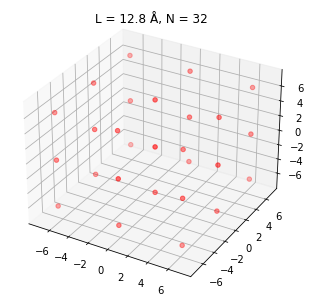

In [160]:
plot_3D_reciprocal_lattice(B, G, SG2, L=L, N=N)

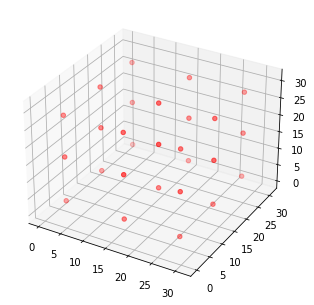

In [90]:
descriptor = make_descriptor(G, SG, L, N)
fig = plt.figure(figsize=(4,4))
ax = Axes3D(fig)


absSG = descriptor.reshape(-1)
max_sg = absSG.max()
colors = [(1.,0.,0.,v) for v in np.maximum(absSG.reshape(-1) / max_sg, 0.0)]
i = np.arange(0, N)
I = np.meshgrid(i, i, i)
ax.scatter(I[0], I[1], I[2], c=colors)
plt.show()

In [44]:
np.meshgrid(ni, ni, ni)

[array([[[ 0,  0,  0, ...,  0,  0,  0],
         [ 1,  1,  1, ...,  1,  1,  1],
         [ 2,  2,  2, ...,  2,  2,  2],
         ...,
         [29, 29, 29, ..., 29, 29, 29],
         [30, 30, 30, ..., 30, 30, 30],
         [31, 31, 31, ..., 31, 31, 31]],
 
        [[ 0,  0,  0, ...,  0,  0,  0],
         [ 1,  1,  1, ...,  1,  1,  1],
         [ 2,  2,  2, ...,  2,  2,  2],
         ...,
         [29, 29, 29, ..., 29, 29, 29],
         [30, 30, 30, ..., 30, 30, 30],
         [31, 31, 31, ..., 31, 31, 31]],
 
        [[ 0,  0,  0, ...,  0,  0,  0],
         [ 1,  1,  1, ...,  1,  1,  1],
         [ 2,  2,  2, ...,  2,  2,  2],
         ...,
         [29, 29, 29, ..., 29, 29, 29],
         [30, 30, 30, ..., 30, 30, 30],
         [31, 31, 31, ..., 31, 31, 31]],
 
        ...,
 
        [[ 0,  0,  0, ...,  0,  0,  0],
         [ 1,  1,  1, ...,  1,  1,  1],
         [ 2,  2,  2, ...,  2,  2,  2],
         ...,
         [29, 29, 29, ..., 29, 29, 29],
         [30, 30, 30, ..., 30, 30, 30],


In [ ]:
get_mesh_coords(np.eye(3)*3, 12.8, 32)

In [12]:
import matplotlib.patches as patches

In [17]:
A = np.array([
    [1., np.sqrt(0.5)],
    [0., np.sqrt(0.5)]
]) * 3
B = 2*np.pi * np.linalg.inv(A).T
L = 12.8
N = 32

In [18]:
m1, m2 = np.meshgrid(mx, my)
M = np.vstack((m1.reshape(1,-1), m2.reshape(1,-1)))
M.shape

(2, 117)

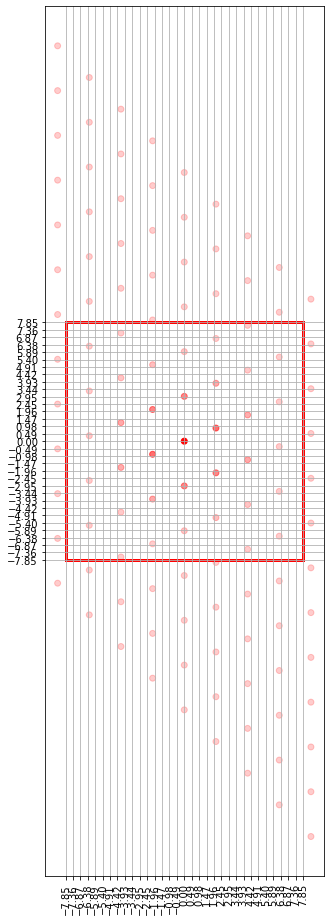

In [19]:
G = B.dot(M)
SG = np.maximum(np.exp(-np.linalg.norm(G, axis=0) / 4), 0.2)
fig, ax = plt.subplots(figsize=(16,16))
colors = [(1.,0.,0.,v) for v in SG]
ax.scatter(G[0,:], G[1,:], c=colors)
width = 2*np.pi / L * N
rect = patches.Rectangle((-width/2, -width/2), width, width, linewidth=3, edgecolor='r', facecolor='none')
ax.add_patch(rect)
ax.set_aspect('equal')
plt.xticks(np.linspace(-width/2, width/2, N+1), rotation = 90)
plt.yticks(np.linspace(-width/2, width/2, N+1))
plt.grid(True)
plt.show()

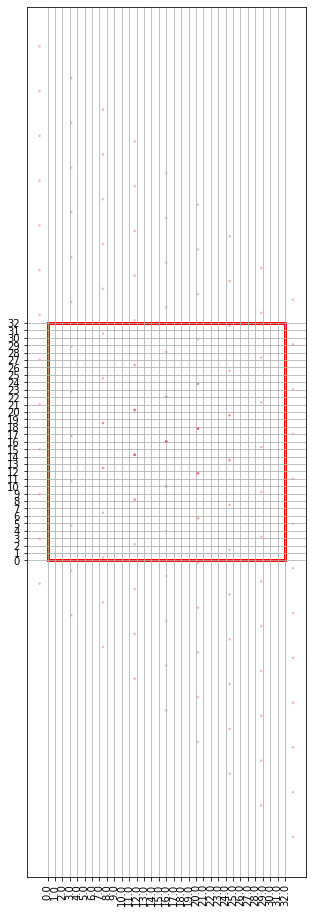

In [20]:
voxel_width = 2*np.pi / L
fig, ax = plt.subplots(figsize=(16,16))
colors = [(1.,0.,0.,v) for v in SG]
tGx = (G[0,:] + width/2) / voxel_width
tGy = (G[1,:] + width/2) / voxel_width
ax.scatter(tGx, tGy, c=colors, s=3)
width = 2*np.pi / L * N
rect = patches.Rectangle((0, 0), N, N, linewidth=3, edgecolor='r', facecolor='none')
ax.add_patch(rect)
ax.set_aspect('equal')
ax.set_xticks(np.linspace(0, N, N+1))
ax.set_xticklabels(ax.get_xticks(), rotation = 90)
ax.set_yticks(np.linspace(0, N, N+1))
plt.grid(True)
plt.show()

In [21]:
descriptor = make_descriptor(G, SG, L, N)
descriptor.shape

(32, 32)

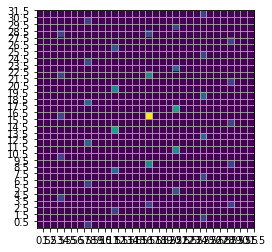

In [22]:
plt.imshow(descriptor, origin='lower')
plt.xticks(np.arange(0,32)+0.5)
plt.yticks(np.arange(0,32)+0.5)
plt.grid(True)

### Centered in Unit Cell

In [ ]:
A = np.eye(2)
gauss = get_nD_gaussian(np.array([[0.5,0.5]]), 0.25, 3, A)
xi, sr = bravais_lattice(gauss, A)
plot_2D_realspace_lattice(A, xi, sr)
B, mi, sg = reciprocal_lattice(gauss, A, g0=-32, g1=32, n=21)
plot_2D_reciprocal_lattice(B, mi, sg)

### Corner of Unit Cell

In [ ]:
A = np.eye(2)
gauss = get_nD_gaussian(np.array([[0.,0.]]), 0.25, 3, A)
xi, sr = bravais_lattice(gauss, A)
plot_2D_realspace_lattice(A, xi, sr)
B, mi, sg = reciprocal_lattice(gauss, A, g0=-8, g1=8)
plot_2D_reciprocal_lattice(B, mi, sg)

### Different Basis

In [ ]:
A = np.array([
    [1., 1.],
    [0., 1.]
])
gauss = get_nD_gaussian(np.array([[0.,0.]]), 0.25, 3, A)
xi, sr = bravais_lattice(gauss, A)
plot_2D_realspace_lattice(A, xi, sr)
plot_2D_bravais_lattice(A, xi, sr)
B, mi, sg = reciprocal_lattice(gauss, A, g0=-8, g1=8)
plot_2D_reciprocal_lattice(B, mi, sg)

In [ ]:
A = np.eye(2)*2
gauss = get_nD_gaussian(np.array([[0.,0.]]), 0.25, 3, np.eye(2))
xi, sr = bravais_lattice(gauss, A)
plot_2D_realspace_lattice(A, xi, sr)
B, mi, sg = reciprocal_lattice(gauss, A, g0=-8, g1=8)
plot_2D_reciprocal_lattice(B, mi, sg)

### Custom Points

In [ ]:
A = np.eye(2)
gauss = get_nD_gaussian(np.array([[0.,0.], [0.5,0.15]]), 0.1, 3, A)
xi, sr = bravais_lattice(gauss, A)
plot_2D_realspace_lattice(A, xi, sr)
B, mi, sg = reciprocal_lattice(gauss, A, g0=-8, g1=8)
plot_2D_reciprocal_lattice(B, mi, sg)

In [ ]:
A = np.eye(2)*2
gauss = get_nD_gaussian(np.array([[0.,0.], [0.5,0.15]]), 0.1, 3, np.eye(2))
xi, sr = bravais_lattice(gauss, A)
plot_2D_realspace_lattice(A, xi, sr)
B, mi, sg = reciprocal_lattice(gauss, A, g0=-8, g1=8)
plot_2D_reciprocal_lattice(B, mi, sg)

## Theoretical Fourier Transform

### Centered in Unit Cell

In [ ]:
A = np.eye(2)
sigma = 0.25
mus = np.array([[0.5,0.5]])
gauss = get_nD_gaussian(mus, sigma, 3, A)
xi, sr = bravais_lattice(gauss, A)
plot_2D_realspace_lattice(A, xi, sr)
B, mi, sg = reciprocal_lattice_gaussian(A, mus, sigma, g0=-8, g1=8)
plot_2D_reciprocal_lattice(B, mi, sg)

### Corner in Unit Sphere and Different Basis

In [ ]:
A = np.array([
    [1., 1.],
    [0., 1.]
])
sigma = 0.25
mus = np.array([[0.,0.]])
gauss = get_nD_gaussian(mus, sigma, 3, A)
xi, sr = bravais_lattice(gauss, A)
plot_2D_realspace_lattice(A, xi, sr)
plot_2D_bravais_lattice(A, xi, sr)
B, mi, sg = reciprocal_lattice_gaussian(A, mus, sigma, g0=-8, g1=8)
plot_2D_reciprocal_lattice(B, mi, sg)

### Custom Points

In [ ]:
A = np.eye(2)
mus = np.array([[0.,0.], [0.5,0.15]])
sigma = 0.1
gauss = get_nD_gaussian(mus, sigma, 3, A)
xi, sr = bravais_lattice(gauss, A)
plot_2D_realspace_lattice(A, xi, sr)
B, mi, sg = reciprocal_lattice_gaussian(A, mus, sigma, g0=-8, g1=8)
plot_2D_reciprocal_lattice(B, mi, sg)

In [ ]:
A = np.eye(2)*2
mus = np.array([
    [0., 0.],
    [0.5, 0.1],
    [0., 1.],
    [1., 0.],
    [1.5, 0.1],
    [0.5, 1.1],
    [1.5, 1.1],
    [1.,1.]
])
sigma = 0.1
gauss = get_nD_gaussian(mus, sigma, 3, A)
xi, sr = bravais_lattice(gauss, A)
plot_2D_realspace_lattice(A, xi, sr)
B, mi, sg = reciprocal_lattice_gaussian(A, mus, sigma, g0=-8, g1=8)
plot_2D_reciprocal_lattice(B, mi, sg)

### 3D

In [ ]:
B, mi, sg = reciprocal_lattice_gaussian(np.eye(3), np.array([[0.,0.,0.]]), 0.1, g0=-8, g1=8)
plot_3D_reciprocal_lattice(B, mi, sg)